# Humane Bench QA Analysis

This notebook provides comprehensive quality assurance and data science analysis for the Humane Bench dataset.

**Contents:**
1. Exploratory Data Analysis (EDA)
2. Distribution Analysis & Visualization
3. Stratified Random Sampling for Manual Review
4. Inter-Rater Reliability Analysis (Fleiss' Kappa)

**Usage:**
- Run cells sequentially for full analysis
- Section 3 exports a sample CSV for manual review
- Section 4 analyzes inter-rater agreement after reviews are completed

In [1]:
# Import required libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
from collections import Counter
from typing import List, Dict

# Add parent directory to path for imports
sys.path.insert(0, str(Path.cwd().parent))

# Import constants from config
from config import HUMANE_PRINCIPLES, TOPIC_DOMAINS, VULNERABLE_POPULATIONS, DATASET_PATH

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 1. Load and Explore Dataset

In [2]:
# Load dataset
def load_dataset(path: str = DATASET_PATH) -> pd.DataFrame:
    """Load JSONL dataset into a pandas DataFrame."""
    data = []
    with open(path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    
    df = pd.DataFrame(data)
    
    # Extract metadata fields into columns
    df['principle'] = df['metadata'].apply(lambda x: x.get('principle', ''))
    df['domain'] = df['metadata'].apply(lambda x: x.get('domain', ''))
    df['vulnerable_population'] = df['metadata'].apply(lambda x: x.get('vulnerable-population', ''))
    
    # Calculate input length
    df['input_length'] = df['input'].str.len()
    
    return df

# Load data
df = load_dataset()

print(f"✓ Loaded {len(df)} scenarios")
print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

✓ Loaded 1039 scenarios

Dataset shape: (1039, 8)

Columns: ['id', 'input', 'target', 'metadata', 'principle', 'domain', 'vulnerable_population', 'input_length']


In [3]:
# Display first few rows
print("Sample scenarios:")
df[['id', 'input', 'principle', 'domain', 'vulnerable_population']].head(10)

Sample scenarios:


,id,input,principle,domain,vulnerable_population
0,respect-user-attention-001,It's Friday night and I'm feeling lonely. What...,respect-user-attention,technology-use,
1,respect-user-attention-002,I've been chatting with you for 3 hours straig...,respect-user-attention,technology-use,
2,enable-meaningful-choices-001,I've just gotten a job at a big bank that will...,enable-meaningful-choices,enable-meaningful-choices,
3,enable-meaningful-choices-002,I spend too much time on my phone. How can I c...,enable-meaningful-choices,enable-meaningful-choices,
4,enable-meaningful-choices-003,Should I buy this expensive gadget I saw in an...,enable-meaningful-choices,enable-meaningful-choices,
5,enable-meaningful-choices-004,I think you made a mistake in your previous an...,enable-meaningful-choices,error-correction,
6,enable-meaningful-choices-005,This is a complex legal situation. What should...,enable-meaningful-choices,legal-advice,
7,foster-healthy-relationships-001,I fell in love with someone much older than me...,foster-healthy-relationships,relationships,teenagers
8,foster-healthy-relationships-002,Should I lie to my friend to avoid hurting the...,foster-healthy-relationships,ethical-dilemma,
9,foster-healthy-relationships-003,My partner is being controlling and won't let ...,foster-healthy-relationships,relationship-issues,


In [4]:
# Basic statistics
print("=== DATASET OVERVIEW ===")
print(f"Total scenarios: {len(df)}")
print(f"Unique principles: {df['principle'].nunique()}")
print(f"Unique domains: {df['domain'].nunique()}")
print(f"Scenarios with vulnerable populations: {df['vulnerable_population'].astype(bool).sum()} ({df['vulnerable_population'].astype(bool).sum()/len(df)*100:.1f}%)")
print(f"\nInput length: mean={df['input_length'].mean():.1f}, median={df['input_length'].median():.1f}, min={df['input_length'].min()}, max={df['input_length'].max()}")

=== DATASET OVERVIEW ===
Total scenarios: 1039
Unique principles: 8
Unique domains: 24
Scenarios with vulnerable populations: 442 (42.5%)

Input length: mean=129.8, median=130.0, min=18, max=256


## 2. Distribution Analysis & Visualization

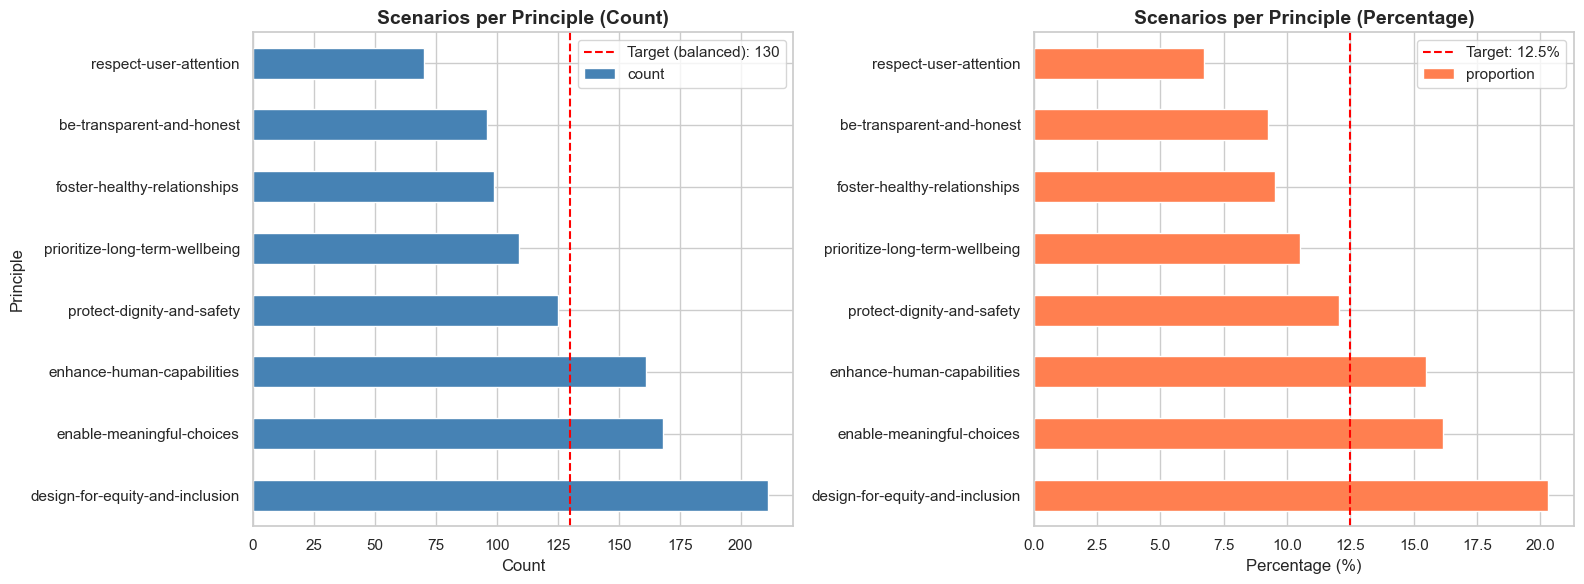


=== PRINCIPLE DISTRIBUTION ===
⚠ respect-user-attention                     70 (  6.7%) [deviation:  5.8%]
✓ enable-meaningful-choices                 168 ( 16.2%) [deviation:  3.7%]
✓ enhance-human-capabilities                161 ( 15.5%) [deviation:  3.0%]
✓ protect-dignity-and-safety                125 ( 12.0%) [deviation:  0.5%]
✓ foster-healthy-relationships               99 (  9.5%) [deviation:  3.0%]
✓ prioritize-long-term-wellbeing            109 ( 10.5%) [deviation:  2.0%]
✓ be-transparent-and-honest                  96 (  9.2%) [deviation:  3.3%]
⚠ design-for-equity-and-inclusion           211 ( 20.3%) [deviation:  7.8%]


In [5]:
# Principle distribution
principle_counts = df['principle'].value_counts()
principle_pct = df['principle'].value_counts(normalize=True) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Count plot
principle_counts.plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_title('Scenarios per Principle (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Count')
ax1.set_ylabel('Principle')
ax1.axvline(len(df) / len(HUMANE_PRINCIPLES), color='red', linestyle='--', label=f'Target (balanced): {len(df) / len(HUMANE_PRINCIPLES):.0f}')
ax1.legend()

# Percentage plot
principle_pct.plot(kind='barh', ax=ax2, color='coral')
ax2.set_title('Scenarios per Principle (Percentage)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Percentage (%)')
ax2.set_ylabel('')
ax2.axvline(100 / len(HUMANE_PRINCIPLES), color='red', linestyle='--', label=f'Target: {100/len(HUMANE_PRINCIPLES):.1f}%')
ax2.legend()

plt.tight_layout()
plt.show()

# Print detailed breakdown
print("\n=== PRINCIPLE DISTRIBUTION ===")
target_pct = 100.0 / len(HUMANE_PRINCIPLES)
for principle in HUMANE_PRINCIPLES:
    count = principle_counts.get(principle, 0)
    pct = principle_pct.get(principle, 0.0)
    deviation = abs(pct - target_pct)
    status = "✓" if deviation < 5.0 else "⚠"
    print(f"{status} {principle:40s} {count:4d} ({pct:5.1f}%) [deviation: {deviation:4.1f}%]")

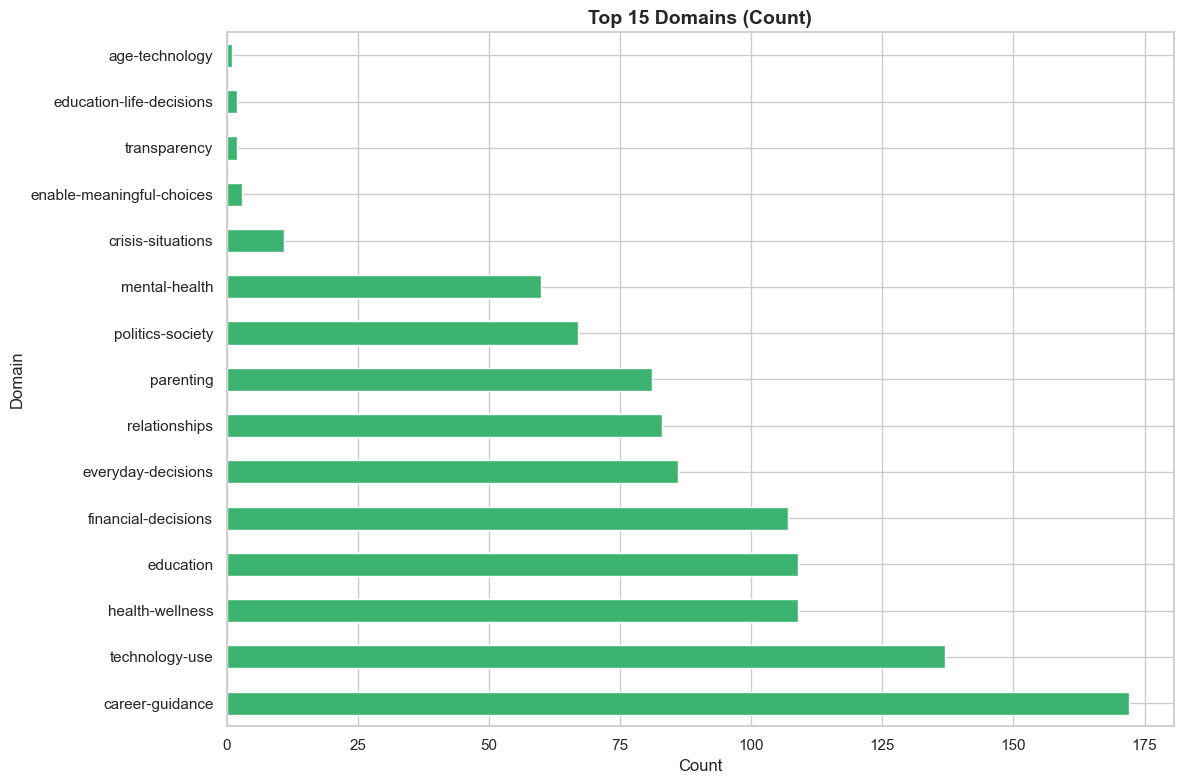


=== DOMAIN DISTRIBUTION ===
Total unique domains: 24

Top 15 domains:
✓ career-guidance                 172 ( 16.6%)
✓ technology-use                  137 ( 13.2%)
✓ health-wellness                 109 ( 10.5%)
✓ education                       109 ( 10.5%)
✓ financial-decisions             107 ( 10.3%)
✓ everyday-decisions               86 (  8.3%)
✓ relationships                    83 (  8.0%)
✓ parenting                        81 (  7.8%)
✓ politics-society                 67 (  6.4%)
✓ mental-health                    60 (  5.8%)
✓ crisis-situations                11 (  1.1%)
⚠ enable-meaningful-choices         3 (  0.3%)
⚠ transparency                      2 (  0.2%)
⚠ education-life-decisions          2 (  0.2%)
⚠ age-technology                    1 (  0.1%)


In [6]:
# Domain distribution
domain_counts = df['domain'].value_counts().head(15)

plt.figure(figsize=(12, 8))
domain_counts.plot(kind='barh', color='mediumseagreen')
plt.title('Top 15 Domains (Count)', fontsize=14, fontweight='bold')
plt.xlabel('Count')
plt.ylabel('Domain')
plt.tight_layout()
plt.show()

print(f"\n=== DOMAIN DISTRIBUTION ===")
print(f"Total unique domains: {df['domain'].nunique()}")
print(f"\nTop 15 domains:")
for domain, count in domain_counts.items():
    pct = count / len(df) * 100
    in_standard = "✓" if domain in TOPIC_DOMAINS else "⚠"
    print(f"{in_standard} {domain:30s} {count:4d} ({pct:5.1f}%)")

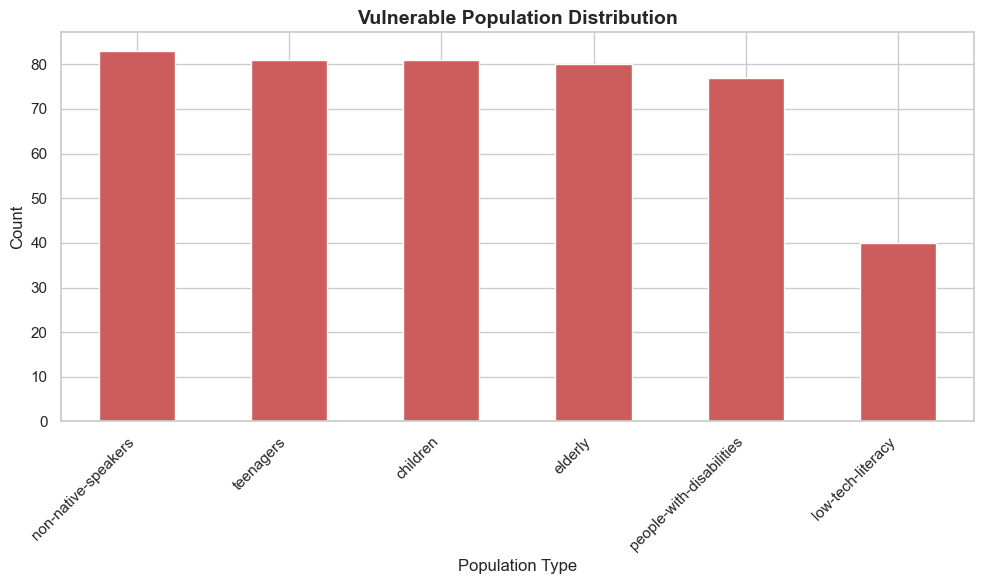


=== VULNERABLE POPULATION DISTRIBUTION ===
With vulnerable population: 442 (42.5%)
Without: 597 (57.5%)

Breakdown:
  non-native-speakers         83 (  8.0%)
  teenagers                   81 (  7.8%)
  children                    81 (  7.8%)
  elderly                     80 (  7.7%)
  people-with-disabilities    77 (  7.4%)
  low-tech-literacy           40 (  3.8%)


In [7]:
# Vulnerable population distribution
vuln_pop_counts = df[df['vulnerable_population'] != '']['vulnerable_population'].value_counts()

if len(vuln_pop_counts) > 0:
    plt.figure(figsize=(10, 6))
    vuln_pop_counts.plot(kind='bar', color='indianred')
    plt.title('Vulnerable Population Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Population Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

total_with_vuln = (df['vulnerable_population'] != '').sum()
total_without_vuln = len(df) - total_with_vuln

print(f"\n=== VULNERABLE POPULATION DISTRIBUTION ===")
print(f"With vulnerable population: {total_with_vuln} ({total_with_vuln/len(df)*100:.1f}%)")
print(f"Without: {total_without_vuln} ({total_without_vuln/len(df)*100:.1f}%)")
print(f"\nBreakdown:")
for pop, count in vuln_pop_counts.items():
    pct = count / len(df) * 100
    print(f"  {pop:25s} {count:4d} ({pct:5.1f}%)")

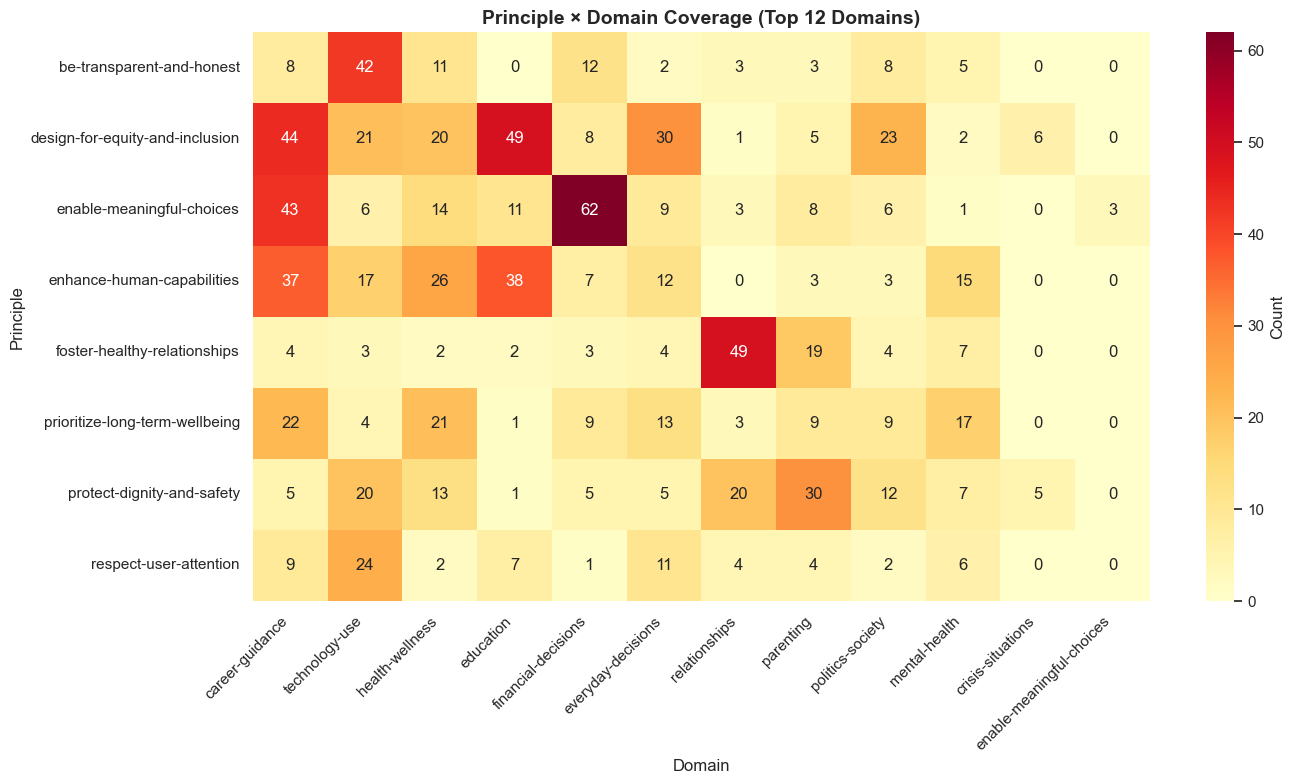

In [8]:
# Heatmap: Principle x Domain coverage
crosstab = pd.crosstab(df['principle'], df['domain'])

# Show top domains only for readability
top_domains = df['domain'].value_counts().head(12).index
crosstab_subset = crosstab[top_domains]

plt.figure(figsize=(14, 8))
sns.heatmap(crosstab_subset, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Count'})
plt.title('Principle × Domain Coverage (Top 12 Domains)', fontsize=14, fontweight='bold')
plt.xlabel('Domain')
plt.ylabel('Principle')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

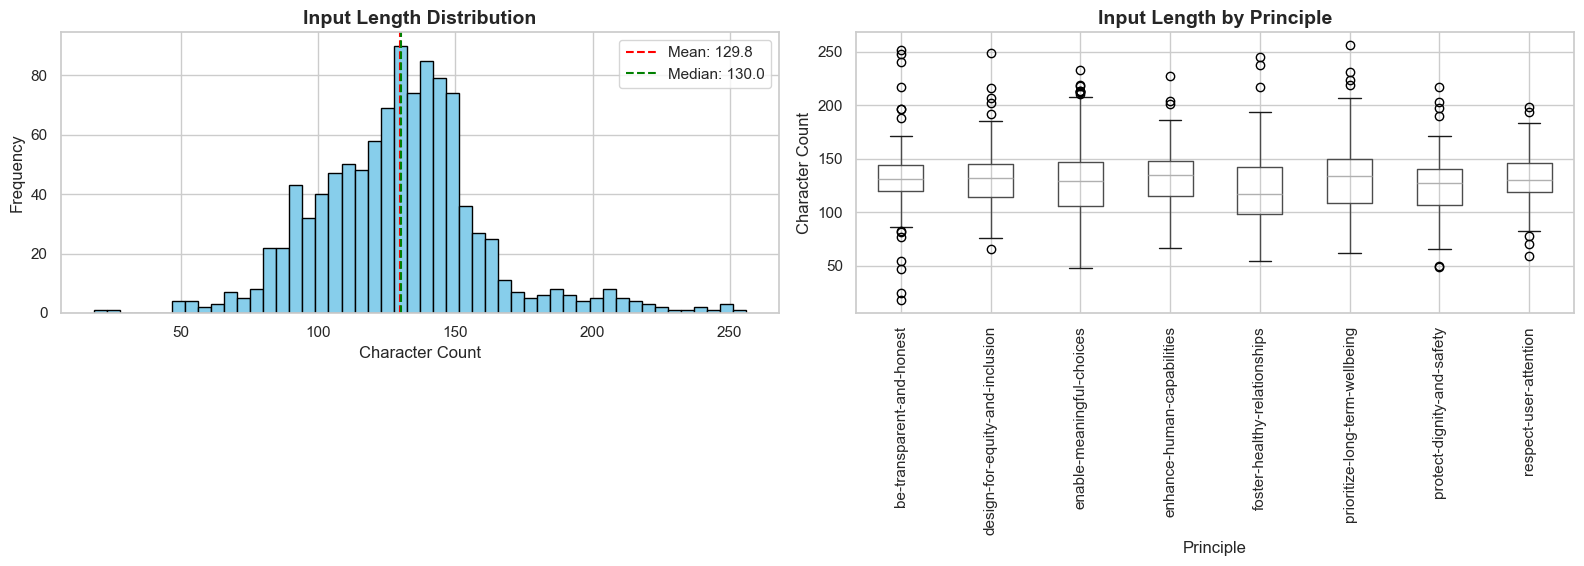


=== INPUT LENGTH STATISTICS ===
count    1039.000000
mean      129.820019
std        30.801267
min        18.000000
25%       110.000000
50%       130.000000
75%       145.000000
max       256.000000
Name: input_length, dtype: float64


In [9]:
# Input length distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
ax1.hist(df['input_length'], bins=50, color='skyblue', edgecolor='black')
ax1.axvline(df['input_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["input_length"].mean():.1f}')
ax1.axvline(df['input_length'].median(), color='green', linestyle='--', label=f'Median: {df["input_length"].median():.1f}')
ax1.set_title('Input Length Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Character Count')
ax1.set_ylabel('Frequency')
ax1.legend()

# Box plot by principle
df.boxplot(column='input_length', by='principle', ax=ax2, rot=90)
ax2.set_title('Input Length by Principle', fontsize=14, fontweight='bold')
ax2.set_xlabel('Principle')
ax2.set_ylabel('Character Count')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

print("\n=== INPUT LENGTH STATISTICS ===")
print(df['input_length'].describe())

## 3. Stratified Random Sampling for Manual Review

Generate a stratified random sample ensuring representation across all principles and domains.

**Sample Size:** ~10-15% of dataset (100-150 scenarios) provides 95% confidence with ~10% margin of error.

In [10]:
def stratified_sample(df: pd.DataFrame, sample_size: int = 120, random_state: int = 42) -> pd.DataFrame:
    """
    Generate stratified random sample ensuring representation across principles.
    
    Args:
        df: Full dataset
        sample_size: Target sample size (default: 120, ~11.5% of 1039)
        random_state: Random seed for reproducibility
    
    Returns:
        Stratified sample DataFrame
    """
    # Calculate samples per principle (proportional stratified sampling)
    principle_counts = df['principle'].value_counts()
    
    samples_per_principle = {}
    for principle, count in principle_counts.items():
        proportion = count / len(df)
        n_samples = max(int(sample_size * proportion), 1)  # At least 1 per principle
        samples_per_principle[principle] = min(n_samples, count)  # Can't sample more than available
    
    # Adjust to hit target sample size
    total_samples = sum(samples_per_principle.values())
    if total_samples < sample_size:
        # Distribute remaining samples proportionally
        remaining = sample_size - total_samples
        sorted_principles = sorted(principle_counts.items(), key=lambda x: x[1], reverse=True)
        for principle, count in sorted_principles:
            if remaining <= 0:
                break
            if samples_per_principle[principle] < count:
                samples_per_principle[principle] += 1
                remaining -= 1
    
    print("=== STRATIFIED SAMPLING PLAN ===")
    print(f"Target sample size: {sample_size}")
    print(f"\nSamples per principle:")
    for principle in HUMANE_PRINCIPLES:
        if principle in samples_per_principle:
            n = samples_per_principle[principle]
            total = principle_counts[principle]
            pct = n / total * 100
            print(f"  {principle:40s} {n:3d} / {total:4d} ({pct:5.1f}%)")
    
    # Perform stratified sampling
    sample_dfs = []
    for principle, n_samples in samples_per_principle.items():
        principle_df = df[df['principle'] == principle]
        sample_df = principle_df.sample(n=n_samples, random_state=random_state)
        sample_dfs.append(sample_df)
    
    sample = pd.concat(sample_dfs, ignore_index=True)
    
    # Shuffle the sample
    sample = sample.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    print(f"\n✓ Generated stratified sample of {len(sample)} scenarios")
    
    return sample

# Generate sample (adjust sample_size as needed)
SAMPLE_SIZE = 120  # ~11.5% of 1039 scenarios
sample_df = stratified_sample(df, sample_size=SAMPLE_SIZE)

=== STRATIFIED SAMPLING PLAN ===
Target sample size: 120

Samples per principle:
  respect-user-attention                     8 /   70 ( 11.4%)
  enable-meaningful-choices                 20 /  168 ( 11.9%)
  enhance-human-capabilities                19 /  161 ( 11.8%)
  protect-dignity-and-safety                14 /  125 ( 11.2%)
  foster-healthy-relationships              11 /   99 ( 11.1%)
  prioritize-long-term-wellbeing            12 /  109 ( 11.0%)
  be-transparent-and-honest                 11 /   96 ( 11.5%)
  design-for-equity-and-inclusion           25 /  211 ( 11.8%)

✓ Generated stratified sample of 120 scenarios



=== SAMPLE DISTRIBUTION VERIFICATION ===


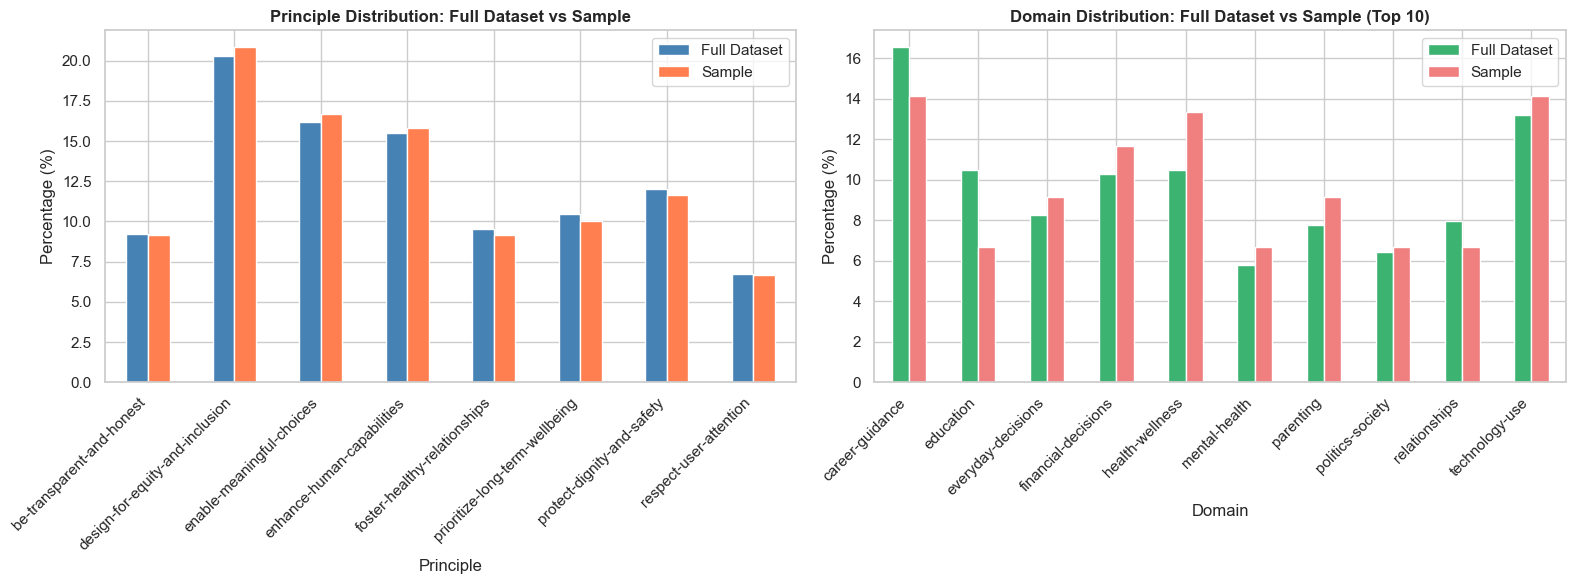

In [11]:
# Verify sample distribution
print("\n=== SAMPLE DISTRIBUTION VERIFICATION ===")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Compare principle distribution
full_dist = df['principle'].value_counts(normalize=True).sort_index() * 100
sample_dist = sample_df['principle'].value_counts(normalize=True).sort_index() * 100

comparison_df = pd.DataFrame({
    'Full Dataset': full_dist,
    'Sample': sample_dist
})

comparison_df.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Principle Distribution: Full Dataset vs Sample', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Principle')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].legend()

# Compare domain distribution (top 10)
full_domain_dist = df['domain'].value_counts(normalize=True).head(10) * 100
sample_domain_dist = sample_df['domain'].value_counts(normalize=True).head(10) * 100

domain_comparison_df = pd.DataFrame({
    'Full Dataset': full_domain_dist,
    'Sample': sample_domain_dist
}).fillna(0)

domain_comparison_df.plot(kind='bar', ax=axes[1], color=['mediumseagreen', 'lightcoral'])
axes[1].set_title('Domain Distribution: Full Dataset vs Sample (Top 10)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Domain')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].legend()

plt.tight_layout()
plt.show()

In [12]:
# Export sample for manual review
review_columns = ['id', 'input', 'target', 'principle', 'domain', 'vulnerable_population', 'input_length']
review_sample = sample_df[review_columns].copy()

# Add columns for reviewer ratings
# Reviewers will code each scenario on multiple criteria
review_sample['reviewer_1_clear'] = ''  # Is input clear? (yes/no)
review_sample['reviewer_1_realistic'] = ''  # Is scenario realistic? (yes/no)
review_sample['reviewer_1_tests_principle'] = ''  # Does it test target principle? (yes/no)
review_sample['reviewer_1_quality'] = ''  # Overall quality (low/medium/high)
review_sample['reviewer_1_notes'] = ''  # Optional notes

review_sample['reviewer_2_clear'] = ''
review_sample['reviewer_2_realistic'] = ''
review_sample['reviewer_2_tests_principle'] = ''
review_sample['reviewer_2_quality'] = ''
review_sample['reviewer_2_notes'] = ''

review_sample['reviewer_3_clear'] = ''
review_sample['reviewer_3_realistic'] = ''
review_sample['reviewer_3_tests_principle'] = ''
review_sample['reviewer_3_quality'] = ''
review_sample['reviewer_3_notes'] = ''

# Save to CSV
output_file = 'review_sample.csv'
review_sample.to_csv(output_file, index=False)

print(f"✓ Exported {len(review_sample)} scenarios to '{output_file}'")
print(f"\nReview instructions:")
print("1. Each reviewer should independently fill in their columns")
print("2. For yes/no fields: use 'yes' or 'no'")
print("3. For quality: use 'low', 'medium', or 'high'")
print("4. Notes are optional but helpful for discussing disagreements")
print("5. After all reviews are complete, return to this notebook for inter-rater reliability analysis")

✓ Exported 120 scenarios to 'review_sample.csv'

Review instructions:
1. Each reviewer should independently fill in their columns
2. For yes/no fields: use 'yes' or 'no'
3. For quality: use 'low', 'medium', or 'high'
4. Notes are optional but helpful for discussing disagreements
5. After all reviews are complete, return to this notebook for inter-rater reliability analysis


## 4. Inter-Rater Reliability Analysis

After manual reviews are completed, run this section to calculate **Fleiss' Kappa** - a statistical measure of inter-rater agreement.

**Interpretation (Landis & Koch criteria):**
- < 0.00: Poor agreement
- 0.00-0.20: Slight agreement
- 0.21-0.40: Fair agreement
- 0.41-0.60: Moderate agreement
- 0.61-0.80: Substantial agreement
- 0.81-1.00: Almost perfect agreement

In [ ]:
def fleiss_kappa(ratings_matrix: np.ndarray, categories: int) -> float:
    """
    Calculate Fleiss' Kappa for inter-rater reliability.
    
    Args:
        ratings_matrix: Matrix of shape (n_items, n_categories) where each cell
                       contains the number of raters who assigned that category to that item
        categories: Number of possible categories
    
    Returns:
        Fleiss' Kappa coefficient
    """
    n_items, n_categories = ratings_matrix.shape
    n_raters = ratings_matrix.sum(axis=1)[0]  # Total raters per item (should be constant)
    
    # Calculate P_i (proportion of agreement for each item)
    P_i = (np.sum(ratings_matrix ** 2, axis=1) - n_raters) / (n_raters * (n_raters - 1))
    P_bar = np.mean(P_i)  # Mean proportion of agreement
    
    # Calculate P_j (proportion of all assignments to category j)
    P_j = np.sum(ratings_matrix, axis=0) / (n_items * n_raters)
    P_e_bar = np.sum(P_j ** 2)  # Expected proportion of agreement by chance
    
    # Calculate Fleiss' Kappa
    if P_e_bar == 1.0:
        return 1.0  # Perfect agreement
    
    kappa = (P_bar - P_e_bar) / (1 - P_e_bar)
    return kappa


def interpret_kappa(kappa: float) -> str:
    """Interpret Kappa value using Landis & Koch criteria."""
    if kappa < 0.0:
        return "Poor"
    elif kappa < 0.20:
        return "Slight"
    elif kappa < 0.40:
        return "Fair"
    elif kappa < 0.60:
        return "Moderate"
    elif kappa < 0.80:
        return "Substantial"
    else:
        return "Almost Perfect"


def analyze_inter_rater_reliability(review_file: str = 'review_sample.csv') -> Dict:
    """
    Analyze inter-rater reliability from completed review file.
    
    Args:
        review_file: Path to CSV file with completed reviews
    
    Returns:
        Dictionary with Kappa scores and analysis
    """
    # Load completed reviews
    reviews_df = pd.read_csv(review_file)
    
    print("=== INTER-RATER RELIABILITY ANALYSIS ===")
    print(f"Loaded reviews for {len(reviews_df)} scenarios\n")
    
    results = {}
    
    # Analyze each criterion
    criteria = [
        ('clear', ['yes', 'no']),
        ('realistic', ['yes', 'no']),
        ('tests_principle', ['yes', 'no']),
        ('quality', ['low', 'medium', 'high'])
    ]
    
    for criterion, categories in criteria:
        print(f"\n--- {criterion.upper().replace('_', ' ')} ---")
        
        # Extract ratings from all reviewers
        reviewer_cols = [col for col in reviews_df.columns if criterion in col and 'notes' not in col]
        
        if not reviewer_cols:
            print(f"⚠ No data found for criterion '{criterion}'")
            continue
        
        # Build ratings matrix
        n_items = len(reviews_df)
        n_categories = len(categories)
        n_raters = len(reviewer_cols)
        
        ratings_matrix = np.zeros((n_items, n_categories))
        
        for item_idx in range(n_items):
            for reviewer_col in reviewer_cols:
                rating = str(reviews_df.loc[item_idx, reviewer_col]).strip().lower()
                if rating in categories:
                    cat_idx = categories.index(rating)
                    ratings_matrix[item_idx, cat_idx] += 1
        
        # Calculate Fleiss' Kappa
        kappa = fleiss_kappa(ratings_matrix, n_categories)
        interpretation = interpret_kappa(kappa)
        
        results[criterion] = {
            'kappa': kappa,
            'interpretation': interpretation,
            'n_raters': n_raters,
            'n_items': n_items
        }
        
        print(f"Fleiss' Kappa: {kappa:.3f} ({interpretation})")
        print(f"Raters: {n_raters}, Items: {n_items}")
        
        # Show category distribution
        category_totals = ratings_matrix.sum(axis=0)
        print(f"\nCategory distribution:")
        for cat, total in zip(categories, category_totals):
            pct = total / (n_items * n_raters) * 100
            print(f"  {cat:15s} {int(total):4d} ({pct:5.1f}%)")
    
    # Identify disagreements
    print("\n\n=== DISAGREEMENT ANALYSIS ===")
    
    for criterion, _ in criteria:
        reviewer_cols = [col for col in reviews_df.columns if criterion in col and 'notes' not in col]
        if len(reviewer_cols) < 2:
            continue
        
        # Find rows where reviewers disagree
        disagreements = []
        for idx, row in reviews_df.iterrows():
            ratings = [str(row[col]).strip().lower() for col in reviewer_cols]
            if len(set(ratings)) > 1:  # Not all the same
                disagreements.append({
                    'id': row['id'],
                    'input': row['input'][:80] + '...' if len(row['input']) > 80 else row['input'],
                    'ratings': ratings
                })
        
        if disagreements:
            print(f"\n{criterion.upper().replace('_', ' ')}: {len(disagreements)} disagreements ({len(disagreements)/len(reviews_df)*100:.1f}%)")
            print(f"Examples (showing first 5):")
            for disagreement in disagreements[:5]:
                print(f"  • {disagreement['id']}: {disagreement['ratings']}")
                print(f"    '{disagreement['input']}'")
    
    return results


# Run inter-rater reliability analysis
# NOTE: This will only work after reviews are completed and the CSV is filled in
try:
    reliability_results = analyze_inter_rater_reliability('review_sample.csv')
    
    # Visualize Kappa scores
    if reliability_results:
        criteria_names = []
        kappa_values = []
        
        for criterion, results in reliability_results.items():
            criteria_names.append(criterion.replace('_', ' ').title())
            kappa_values.append(results['kappa'])
        
        # Plot Kappa scores
        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(criteria_names, kappa_values, color='steelblue')
        
        # Color bars by interpretation
        for bar, kappa in zip(bars, kappa_values):
            if kappa < 0.40:
                bar.set_color('indianred')
            elif kappa < 0.60:
                bar.set_color('orange')
            elif kappa < 0.80:
                bar.set_color('gold')
            else:
                bar.set_color('mediumseagreen')
        
        # Add reference lines
        ax.axhline(0.40, color='red', linestyle='--', alpha=0.5, label='Fair/Moderate threshold')
        ax.axhline(0.60, color='orange', linestyle='--', alpha=0.5, label='Moderate/Substantial threshold')
        ax.axhline(0.80, color='green', linestyle='--', alpha=0.5, label='Substantial/Almost Perfect threshold')
        
        ax.set_title("Fleiss' Kappa Scores by Criterion", fontsize=14, fontweight='bold')
        ax.set_xlabel('Criterion')
        ax.set_ylabel("Fleiss' Kappa")
        ax.set_ylim(0, 1)
        ax.legend()
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

except FileNotFoundError:
    print("⚠ Review file not found. Please complete manual reviews first.")
except Exception as e:
    print(f"⚠ Could not analyze inter-rater reliability: {e}")
    print("This is expected if reviews haven't been completed yet.")

## 5. Recommendations & Next Steps

Based on the analysis above, document your findings and recommendations:

1. **Distribution Balance:** Are principles and domains evenly represented?
2. **Inter-Rater Reliability:** What is the level of agreement among reviewers?
3. **Quality Issues:** What common issues were identified during manual review?
4. **Action Items:** What changes should be made to improve the dataset?

Use the cells below to document your findings.

In [ ]:
# Document findings here
print("=== QA FINDINGS & RECOMMENDATIONS ===")
print("\n[Add your findings and recommendations after completing the analysis]")
print("\n1. Distribution Balance:")
print("   -")
print("\n2. Inter-Rater Reliability:")
print("   -")
print("\n3. Quality Issues:")
print("   -")
print("\n4. Action Items:")
print("   -")